## Seung Jun Choi in Urban Information Lab
## Public Health Application: Skin Cancer Detection 
https://www.thepythoncode.com/article/skin-cancer-detection-using-tensorflow-in-python

Skin cancer is an abnormal growth of skin cells, it is one of the most common cancers and unfortunately, it can become deadly. The good news though is when caught early, your dermatologist can treat it and eliminate it entirely.

Using deep learning and neural networks, we'll be able to classify benign and malignant skin diseases, which may help the doctor diagnose cancer at an earlier stage. In this tutorial, we will make a skin disease classifier that tries to distinguish between benign (nevus and seborrheic keratosis) and malignant (melanoma) skin diseases from only photographic images using TensorFlow framework in Python.

To get started, let's install the required libraries:

In [9]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.utils import get_file
from sklearn.metrics import roc_curve, auc, confusion_matrix
from imblearn.metrics import sensitivity_score, specificity_score

In [10]:
import os
import glob
import zipfile
import random

# to get consistent results after multiple runs
tf.random.set_seed(7)
np.random.seed(7)
random.seed(7)

# 0 for benign, 1 for malignant
class_names = ["benign", "malignant"]

Preparing the Dataset
For this tutorial, we'll be using only a small part of ISIC archive dataset, the below function downloads and extract the dataset into a new data folder:

This will take several minutes depending on your connection, after that, the data folder will appear that contains the training, validation and testing sets. Each set is a folder that has three categories of skin disease images (nevus, seborrheic_keratosis and melanoma).

Note: You may struggle to download the dataset using the above Python function when you have a slow Internet connection, in that case, you should download it and extract it manually in the folder data in the current directory.

In [ ]:
def download_and_extract_dataset():
  # dataset from https://github.com/udacity/dermatologist-ai
  # 5.3GB
  train_url = "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip"
  # 824.5MB
  valid_url = "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip"
  # 5.1GB
  test_url  = "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip"
  for i, download_link in enumerate([valid_url, train_url, test_url]):
    temp_file = f"temp{i}.zip"
    data_dir = get_file(origin=download_link, fname=os.path.join(os.getcwd(), temp_file))
    print("Extracting", download_link)
    with zipfile.ZipFile(data_dir, "r") as z:
      z.extractall("data")
    # remove the temp file
    os.remove(temp_file)

# comment the below line if you already downloaded the dataset
download_and_extract_dataset()

Now that we have the dataset in our machine, let's find a way to label these images, remember we're going to classify only benign and malignant skin diseases, so we need to label nevus and seborrheic keratosis as the value 0 and melanoma 1.

The below cell generates a metadata CSV file for each set, each row in the CSV file corresponds to a path to an image along with its label (0 or 1):

# preparing data
# generate CSV metadata file to read img paths and labels from it

def generate_csv(folder, label2int):
    folder_name = os.path.basename(folder)
    labels = list(label2int)
    # generate CSV file
    df = pd.DataFrame(columns=["filepath", "label"])
    i = 0
    for label in labels:
        print("Reading", os.path.join(folder, label, "*"))
        for filepath in glob.glob(os.path.join(folder, label, "*")):
            df.loc[i] = [filepath, label2int[label]]
            i += 1
    output_file = f"{folder_name}.csv"
    print("Saving", output_file)
    df.to_csv(output_file)

In [ ]:
# generate CSV files for all data portions, labeling nevus and seborrheic keratosis
# as 0 (benign), and melanoma as 1 (malignant)
# you should replace "data" path to your extracted dataset path
# don't replace if you used download_and_extract_dataset() function
generate_csv("data/train", {"nevus": 0, "seborrheic_keratosis": 0, "melanoma": 1})
generate_csv("data/valid", {"nevus": 0, "seborrheic_keratosis": 0, "melanoma": 1})
generate_csv("data/test", {"nevus": 0, "seborrheic_keratosis": 0, "melanoma": 1})

The generate_csv() function accepts 2 arguments, the first is the path of the set, for example, if you have downloaded and extract the dataset in "E:\datasets\skin-cancer", then the training set should be something like "E:\datasets\skin-cancer\train".

The second parameter is a dictionary that maps each skin disease category to its corresponding label value (again, 0 for benign and 1 for malignant).

The reason I did a function like this is the ability to use it on other skin disease classifications (such as melanocytic classification), so you can add more skin diseases and use it for other problems as well.

Once you run the cell, you notice that 3 CSV files will appear in your current directory. Now let's use the from_tensor_slices() method from tf.data API to load these metadata files:

In [ ]:
# loading data
train_metadata_filename = "train.csv"
valid_metadata_filename = "valid.csv"

# load CSV files as DataFrames
df_train = pd.read_csv(train_metadata_filename)
df_valid = pd.read_csv(valid_metadata_filename)

n_training_samples = len(df_train)
n_validation_samples = len(df_valid)

print("Number of training samples:", n_training_samples)
print("Number of validation samples:", n_validation_samples)

train_ds = tf.data.Dataset.from_tensor_slices((df_train["filepath"], df_train["label"]))
valid_ds = tf.data.Dataset.from_tensor_slices((df_valid["filepath"], df_valid["label"]))

Now we have loaded the dataset (train_ds and valid_ds), each sample is a tuple of filepath (path to the image file) and label (0 for benign and 1 for malignant), here is the output:

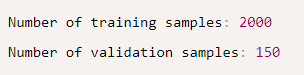

Let's load the images:
# Preprocessing

In [ ]:
# preprocess data
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [299, 299])

In [ ]:
def process_path(filepath, label):
  # load the raw data from the file as a string
  img = tf.io.read_file(filepath)
  img = decode_img(img)
  return img, label

In [ ]:
valid_ds = valid_ds.map(process_path)
train_ds = train_ds.map(process_path)
# test_ds = test_ds
for image, label in train_ds.take(1):
    print("Image shape:", image.shape)
    print("Label:", label.numpy())

The above code uses map() method to execute process_path() function on each sample on both sets, it'll basically load the images, decode the image format, convert the image pixels to be in the range [0, 1] and resize it to (299, 299, 3), we then take one image and print its shape:

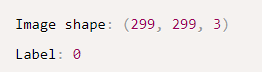

Everything is as expected, now let's prepare this dataset for training:

In [ ]:
# training parameters
batch_size = 64
optimizer = "rmsprop"

In [ ]:
def prepare_for_training(ds, cache=True, batch_size=64, shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  # shuffle the dataset
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  # Repeat forever
  ds = ds.repeat()
  # split to batches
  ds = ds.batch(batch_size)
  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return ds

valid_ds = prepare_for_training(valid_ds, batch_size=batch_size, cache="valid-cached-data")
train_ds = prepare_for_training(train_ds, batch_size=batch_size, cache="train-cached-data")

Here is what we did:

cache(): Since we're making too many calculations on each set, we used cache() method to save our preprocessed dataset into a local cache file, this will only preprocess it the very first time (in the first epoch during training).

shuffle(): To basically shuffle the dataset, so the samples are in random order.

repeat(): Every time we iterate over the dataset, it'll keep generating samples for us repeatedly, this will help us during the training.

batch(): We batch our dataset into 64 or 32 samples per training step.

prefetch(): This will enable us to fetch batches in the background while the model is training.

The below cell gets the first validation batch and plots the images along with their corresponding label:

In [ ]:
batch = next(iter(valid_ds))

def show_batch(batch):
  plt.figure(figsize=(12,12))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(batch[0][n])
      plt.title(class_names[batch[1][n].numpy()].title())
      plt.axis('off')
        
show_batch(batch)

In [12]:
#output

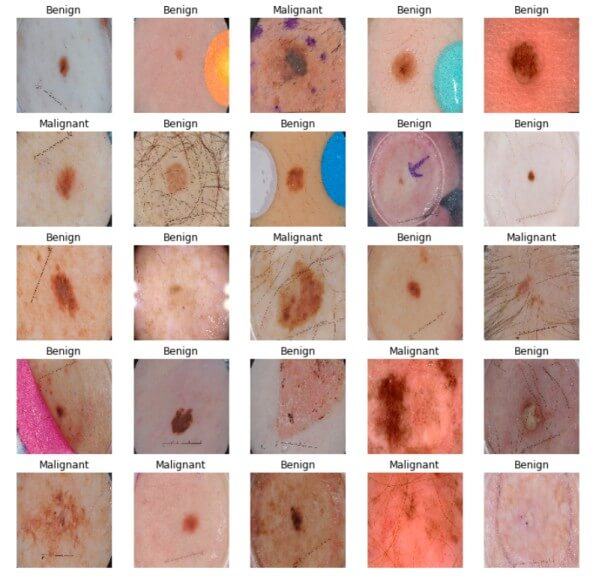

As you can see, it's extremely hard to differentiate between malignant and benign diseases, let's see how our model will deal with it.

Great, now our dataset is ready, let's dive into building our model.

Notice before, we resized all images to (299, 299, 3), and that's because of what InceptionV3 architecture expects as input, so we'll be using transfer learning with TensorFlow Hub library to download and load the InceptionV3 architecture along with its ImageNet pre-trained weights:

In [ ]:
# building the model
# InceptionV3 model & pre-trained weights
module_url = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
m = tf.keras.Sequential([
    hub.KerasLayer(module_url, output_shape=[2048], trainable=False),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

m.build([None, 299, 299, 3])
m.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
m.summary()

We set trainable to False so we won't be able to adjust the pre-trained weights during our training, we also added a final output layer with 1 unit that is expected to output a value between 0 and 1 (close to 0 means benign, and 1 for malignant).

After that, since this is a binary classification, we built our model using binary crossentropy loss, and used accuracy as our metric (not that reliable metric, we'll see sooner why), here is the output of our model summary:

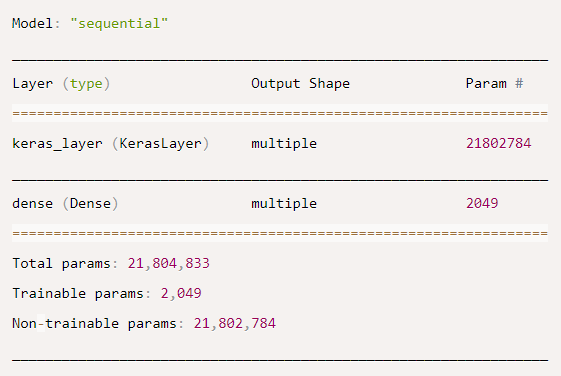

## Training the Model

We now have our dataset and the model, let's get them together:

In [ ]:
model_name = f"benign-vs-malignant_{batch_size}_{optimizer}"
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=os.path.join("logs", model_name))
# saves model checkpoint whenever we reach better weights
modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(model_name + "_{val_loss:.3f}.h5", save_best_only=True, verbose=1)

history = m.fit(train_ds, validation_data=valid_ds, 
                steps_per_epoch=n_training_samples // batch_size, 
                validation_steps=n_validation_samples // batch_size, verbose=1, epochs=100,
                callbacks=[tensorboard, modelcheckpoint])

We're using ModelCheckpoint callback to save the best weights so far on each epoch, that's why I set epochs to 100, that's because it can converge to better weights at any time, to save your time, feel free to reduce that to 30 or so.

I also added tensorboard as a callback in case you want to experiment with different hyperparameter values.

Since fit() method doesn't know the number of samples there are in the dataset, we need to specify steps_per_epoch and validation_steps parameters for the number of iterations (the number of samples divided by the batch size) of the training set and validation set respectively.

Here is a part of the output during training:

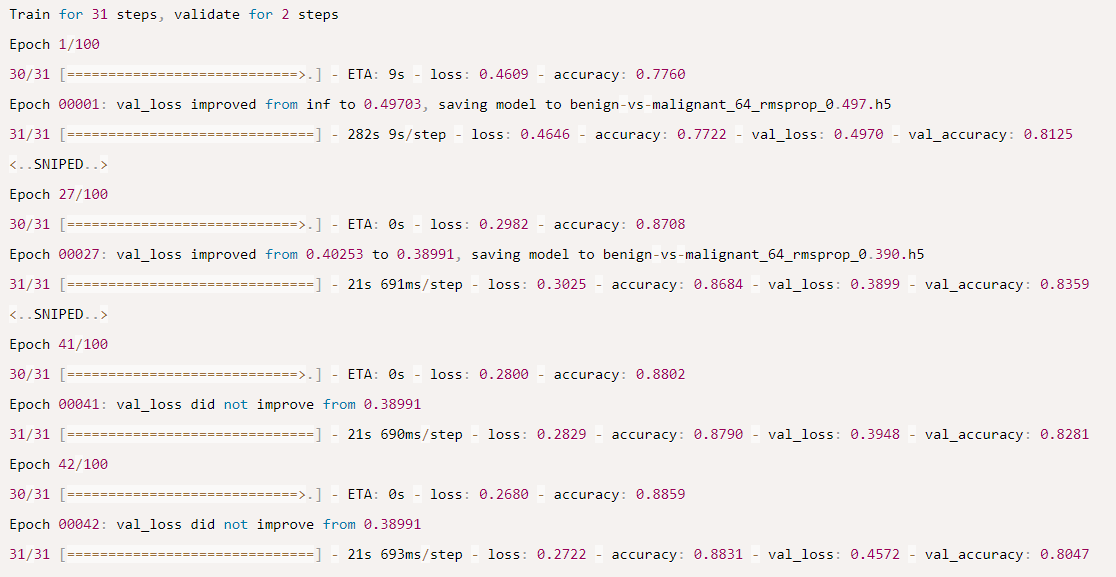

## Model Evaluation

First, let's load our test set, just like previously:

In [ ]:
# evaluation
# load testing set
test_metadata_filename = "test.csv"
df_test = pd.read_csv(test_metadata_filename)
n_testing_samples = len(df_test)
print("Number of testing samples:", n_testing_samples)
test_ds = tf.data.Dataset.from_tensor_slices((df_test["filepath"], df_test["label"]))

def prepare_for_testing(ds, cache=True, shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  return ds

test_ds = test_ds.map(process_path)
test_ds = prepare_for_testing(test_ds, cache="test-cached-data")

The above code loads our test data and prepares it for testing:

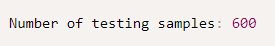

600 images of the shape (299, 299, 3) can fit our memory, let's convert our test set from tf.data into a NumPy array:

In [ ]:
# convert testing set to numpy array to fit in memory (don't do that when testing
# set is too large)
y_test = np.zeros((n_testing_samples,))
X_test = np.zeros((n_testing_samples, 299, 299, 3))
for i, (img, label) in enumerate(test_ds.take(n_testing_samples)):
  # print(img.shape, label.shape)
  X_test[i] = img
  y_test[i] = label.numpy()

print("y_test.shape:", y_test.shape)

The above cell will construct our arrays, it will take some time the first time it's executed because it's doing all the preprocessing defined in process_path() and prepare_for_testing() functions.

Now let's load our optimal weights that were saved by ModelCheckpoint during the training:

In [ ]:
# load the weights with the least loss
m.load_weights("benign-vs-malignant_64_rmsprop_0.390.h5")

You may not have the exact filename of the optimal weights, you need to search for the saved weights in the current directory that has the least loss, the below code evaluates the model using accuracy metric:

In [ ]:
print("Evaluating the model...")
loss, accuracy = m.evaluate(X_test, y_test, verbose=0)
print("Loss:", loss, "  Accuracy:", accuracy)

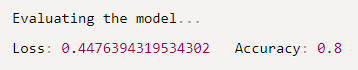

We've reached about 84% accuracy on the validation set and 80% on the test set, but that's not all. Since our dataset is largely unbalanced, accuracy doesn't tell everything. In fact, a model that predicts every image as benign would get an accuracy of 80%, since malignant samples are about 20% of the total validation set.

As a result, we need a better way to evaluate our model, in the upcoming cells, we'll use seaborn and matplotlib libraries to draw the confusion matrix that tells us more about how well our model is doing.

But before we do that, I just want to make something clear: we all know that predicting a malignant disease as benign is a terrible mistake, you can kill people doing that! So we need a way to predict even more malignant cases even that we have very few malignant samples compared to benign. A good method is introducing a threshold.

Remember the output of the neural network is a value between 0 and 1. In the normal way, when the neural network produces a value between 0 and 0.5, we automatically assign it as benign, and from 0.5 to 1.0 as malignant. And since we want to be aware of the fact that we can predict a malignant disease as benign (that's only one of the many reasons), we can say for example, from 0 to 0.3 is benign, and from 0.3 to 1.0 is malignant, this means we are using a threshold value of 0.3, this will improve our predictions.

The below function does that:

In [ ]:
def get_predictions(threshold=None):
  """
  Returns predictions for binary classification given `threshold`
  For instance, if threshold is 0.3, then it'll output 1 (malignant) for that sample if
  the probability of 1 is 30% or more (instead of 50%)
  """
  y_pred = m.predict(X_test)
  if not threshold:
    threshold = 0.5
  result = np.zeros((n_testing_samples,))
  for i in range(n_testing_samples):
    # test melanoma probability
    if y_pred[i][0] >= threshold:
      result[i] = 1
    # else, it's 0 (benign)
  return result

threshold = 0.23
# get predictions with 23% threshold
# which means if the model is 23% sure or more that is malignant,
# it's assigned as malignant, otherwise it's benign
y_pred = get_predictions(threshold)

Now let's draw our confusion matrix and interpret it:

In [ ]:
def plot_confusion_matrix(y_test, y_pred):
  cmn = confusion_matrix(y_test, y_pred)
  # Normalise
  cmn = cmn.astype('float') / cmn.sum(axis=1)[:, np.newaxis]
  # print it
  print(cmn)
  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(cmn, annot=True, fmt='.2f', 
              xticklabels=[f"pred_{c}" for c in class_names], 
              yticklabels=[f"true_{c}" for c in class_names],
              cmap="Blues"
              )
  plt.ylabel('Actual')
  plt.xlabel('Predicted')

  # plot the resulting confusion matrix
  plt.show()

plot_confusion_matrix(y_test, y_pred)

In [14]:
#Output

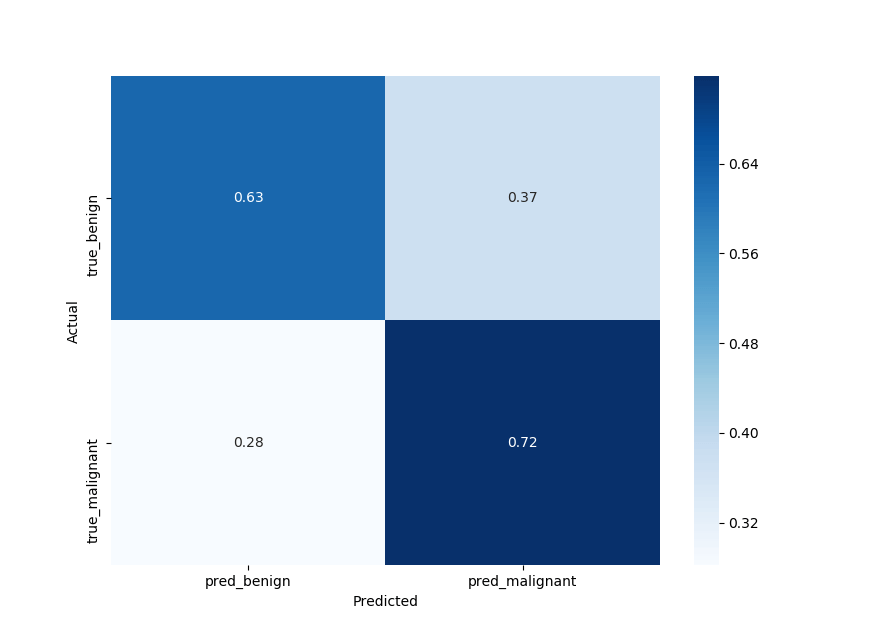

So our model gets about 0.72 probability of a positive test given that the patient has the disease (bottom right of the confusion matrix), that's often called sensitivity.

Sensitivity is a statistical measure that is widely used in medicine that is given by the following formula:

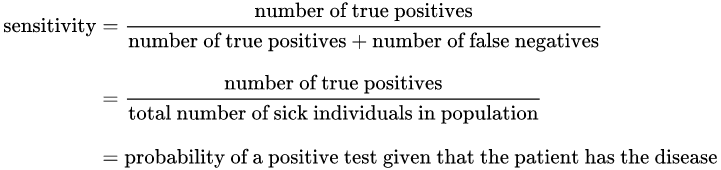

So in our example, out of all patients that have a malignant skin disease, we successfully predicted 72% of them as malignant, not bad but needs improvements.

The other metric is specificity, you can read it in the top left of the confusion matrix, we got about 63%. It is basically the probability of a negative test given that the patient is well:

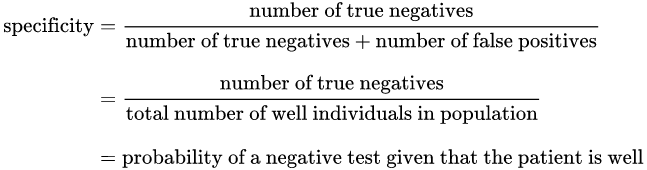

In our example, out of all patients that has a benign, we predicted 63% of them as benign.

With high specificity, the test rarely gives positive results in healthy patients, whereas a high sensitivity means that the model is reliable when its result is negative, I invite you to read more about it in this Wikipedia article.

Alternatively, you can use imblearn module to get these scores:

In [ ]:
sensitivity = sensitivity_score(y_test, y_pred)
specificity = specificity_score(y_test, y_pred)

print("Melanoma Sensitivity:", sensitivity)
print("Melanoma Specificity:", specificity)

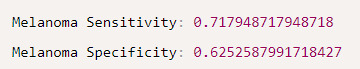

## Receiver Operating Characteristic
Another good metric is ROC, which is basically a graphical plot that shows us the diagnostic ability of our binary classifier, it features a true positive rate on the Y-axis and a false-positive rate on the X-axis. The perfect point we want to reach is in the top left corner of the plot, here is the code for plotting the ROC curve using matplotlib:

In [ ]:
def plot_roc_auc(y_true, y_pred):
    """
    This function plots the ROC curves and provides the scores.
    """
    # prepare for figure
    plt.figure()
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    # obtain ROC AUC
    roc_auc = auc(fpr, tpr)
    # print score
    print(f"ROC AUC: {roc_auc:.3f}")
    # plot ROC curve
    plt.plot(fpr, tpr, color="blue", lw=2,
                label='ROC curve (area = {f:.2f})'.format(d=1, f=roc_auc))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_auc(y_test, y_pred)

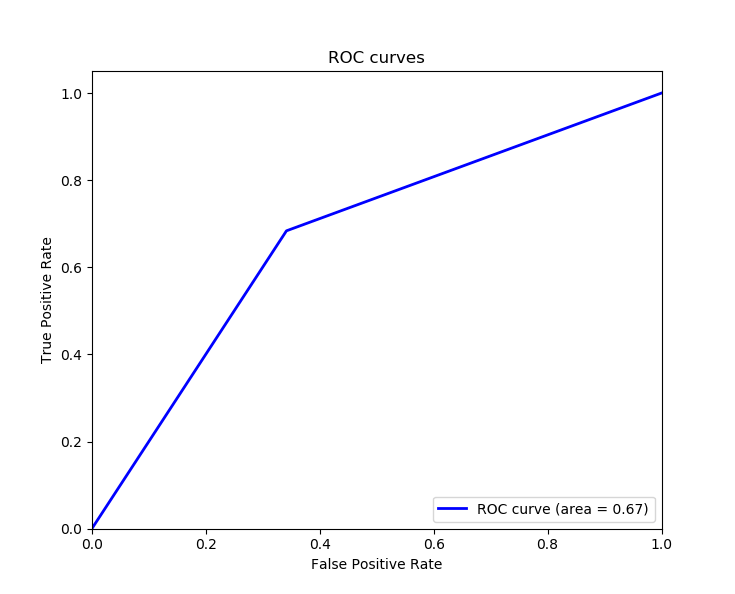

ROC AUC: 0.671

## Conclusion

We're done! There you have it, see how you can improve the model, we only used 2000 training samples, go to ISIC archive and download more and add them to the data folder, the scores will improve significantly depending on the number of samples you add. You can use ISIC archive downloader which may help you download the dataset in the way you want.

I also encourage you to tweak the hyperparameters such as the threshold we set earlier, and see if you can get better sensitivity and specificity scores.

I used InceptionV3 model architecture, you're free to use any CNN architecture you want, I invite you to browse TensorFlow hub and choose the newest model. For example, in satellite image classification, we've chosen EfficientNET V2, try it out and you may increase the performance significantly!

## References

Dermatologist-level classification of skin cancer with deep neural networks
https://www.nature.com/articles/nature21056.epdf

Dermatologist AI
https://github.com/udacity/dermatologist-ai

## Health Predictive Modules: Pyhealth

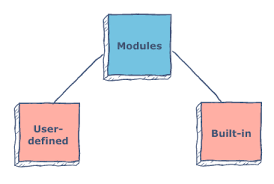

PyHealth is a comprehensive Python package for healthcare AI, designed for both ML researchers and healthcare and medical practitioners. PyHealth accepts diverse healthcare data such as longitudinal electronic health records (EHRs), continuous signials (ECG, EEG), and clinical notes (to be added), and supports various predictive modeling methods using deep learning and other advanced machine learning algorithms published in the literature.

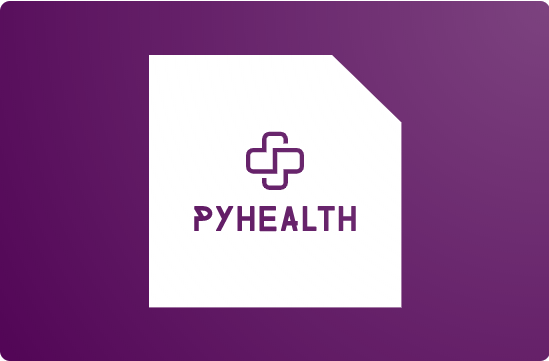

PyHealth is a comprehensive Python package for healthcare AI, designed for both ML researchers and healthcare and medical practitioners. PyHealth accepts diverse healthcare data such as longitudinal electronic health records (EHRs), continuous signials (ECG, EEG), and clinical notes (to be added), and supports various predictive modeling methods using deep learning and other advanced machine learning algorithms published in the literature.

The library is proudly developed and maintained by researchers from Carnegie Mellon University, IQVIA, and University of Illinois at Urbana-Champaign. PyHealth makes many important healthcare tasks become accessible, such as phenotyping prediction, mortality prediction, and ICU length stay forecasting, etc. Running these prediction tasks with deep learning models can be as short as 10 lines of code in PyHealth.

PyHealth comes with three major modules: (i) data preprocessing module; (ii) learning module and (iii) evaluation module. Typically, one can run the data prep module to prepare the data, then feed to the learning module for model training and prediction, and finally assess the results with the evaluation module. Users can use the full system as mentioned or just selected modules based on their own needs:

Deep learning researchers may directly use the processed data along with the proposed new models.
Healthcare and Medical personnel, may leverage our data preprocessing module to convert the medical data to the format that machine learning models could digest, and then perform the inference tasks to get insights from the data. This package can support them in various health analytics tasks including disease detection, risk prediction, patient subtyping, health monitoring, etc.

In [2]:
pip install pyhealth

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lightgbm 3.3.1 requires scikit-learn!=0.22.0, but you have scikit-learn 0.22 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.22 which is incompatible.
forestci 0.5.1 requires scikit-learn>=0.23.1, but you have scikit-learn 0.22 which is incompatible.


  Created wheel for pyhealth: filename=pyhealth-0.0.6-py3-none-any.whl size=191432 sha256=26c2b4e1328272f6b4953a2b520b008a19c4df2436346926c12a3bf35add1a98
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\47\c1\1b\da6aa68bd862c43c9c600d6b9868a06dcb8dabb32724a96761
  Created wheel for combo: filename=combo-0.1.3-py3-none-any.whl size=42871 sha256=9e64fcfd2311ce216745fc2d076148f907b40a0ad725c8c82e0062d509e088e7
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\ec\44\39\0667fea44a2dfe692cc2a51f0f79ea49b9dee7def53594ef2e
  Created wheel for pyod: filename=pyod-0.9.9-py3-none-any.whl size=139312 sha256=9cb5afd826230cf1636ac1c25fe9cf4adfbb86e0dba8c4535a7c01d0e53a1a88
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\12\26\e9\d46b2360d356003c84269ee2d0d7a1323b790efe868546534c
Successfully built pyhealth combo pyod
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:

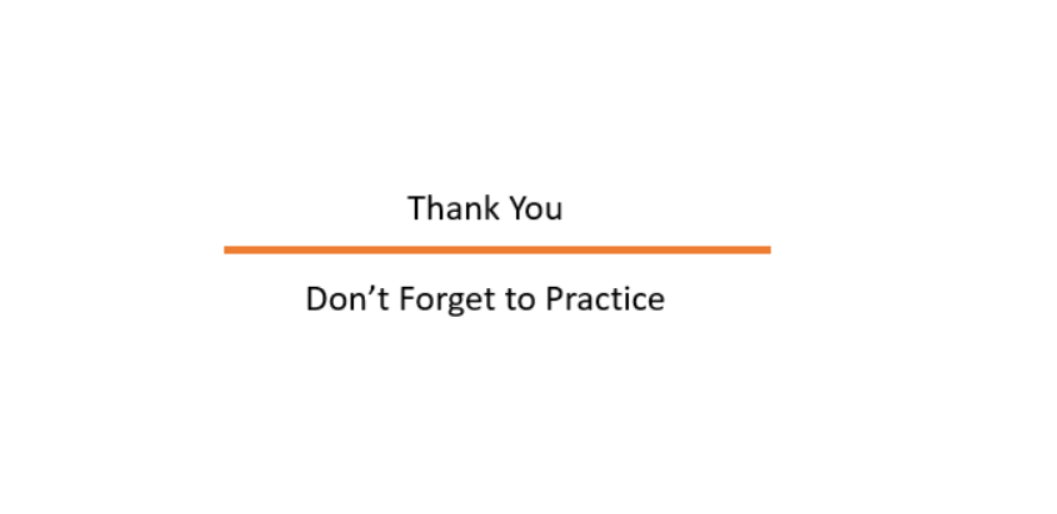